# Lab: Coding Vision Transformers in Pytorch

For any remark or suggestion on this lab, please feel free to contact me at:

- loic.lefolgoc@telecom-paris.fr

### Objective:

We want to implement a Vision Transformer (ViT) for image recognition. We will use this model on a well-known dataset: CIFAR-10 https://www.cs.toronto.edu/~kriz/cifar.html.

The model will be implemented using the Pytorch environment : https://pytorch.org/.
    
### Your task:
You need to add the missing parts in the code (generally marked by `...`)

# Load packages

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [62]:
from tqdm import tqdm

In [63]:
!pip install einops

In [64]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Load the dataset: CIFAR-10

We are going to train a vision transformer on a well-known vision dataset : CIFAR10. CIFAR10 consists of $60,000$ $32\times 32$ color images of $10$ different object classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [65]:
# The CIFAR10 categories
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

We import the CIFAR-10 data and carry out some pre-processing :

In [66]:
# Convert input to Pytorch tensors
input_transform=transforms.Compose( [transforms.ToTensor()])

# Retrieve CIFAR training data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=input_transform)
print(cifar_trainset)

# Retrieve test data
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=input_transform)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Files already downloaded and verified


### Display some of the images

In [67]:
# Extract the test data and labels for visualization
X_test = torch.from_numpy(cifar_testset.data/255.0).float().permute(0,3,1,2)
Y_test = torch.tensor(cifar_testset.targets, dtype=torch.uint8)

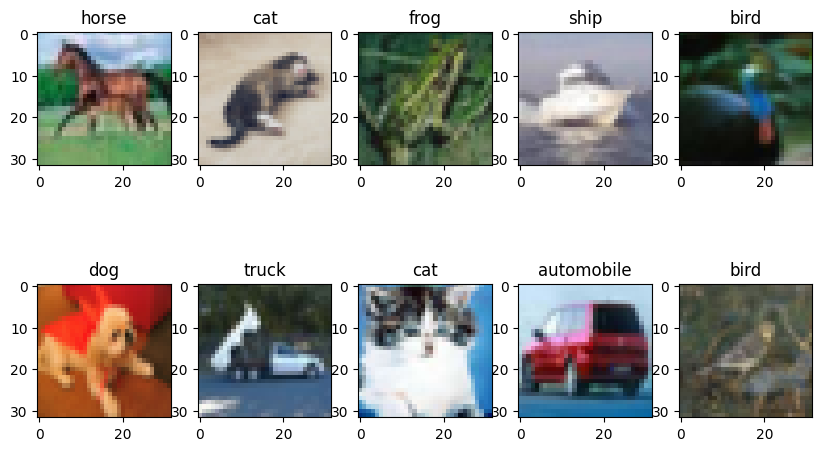

In [68]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    plt.imshow(X_test[rand_ind,:,:,:].permute(1,2,0))
    plt.title(cifar_10_list[int(Y_test[rand_ind])])

# Build a generic ViT (Vision Transformer) model

A ViT has a patch embedding section, which splits an image into patches and projects them to patch embeddings. These embeddings are slightly modified (a [cls] token is added, positional embeddings are added) then fed to the main body of the transformer.

The transformer consists of several transformer encoder blocks (MHSA and MLP layers), plus a final classification head (a linear projection layer).

<br> Transformers make heavy use of the `einops.rearrange` function. Take a bit of time to go through the documentation and example uses of this function: https://einops.rocks/1-einops-basics/.

It will be very useful to you beyond transformers, and will make your code much more readable than alternatives!

<br>We are going to build the model step-by-step. First, we focus on the patch embedding. Fill in the missing parts in the `PatchEmbedding` class. You can then test your implementation by running the cell right below it.

The attribute `self.net` is a `nn.Sequential` object that is used in the forward pass to convert images to sequences of flattened patches. It contains the following layers:
- a `Rearrange` layer from `einops.layers.torch` that reshapes the batch of input images into a batch of sequences of flattened patches: `(b, c, H, W) → (b, N, D_p)` where `H=h*patch_height`, `W=w*patch_width`, `N=h*w`, `D_p=patch_height*patch_width*c`;
- a `LayerNorm` layer, which computes the mean/variance separately for each token in the sequence (i.e. mean/variance over the `D_p` patch entries);
- a `Linear` layer, which projects each token from `D_p` to `dim` dimensions;
- a `LayerNorm` layer, which computes the mean/variance separately for each token in the sequence (i.e. mean/variance over the `dim` embedding dimensions).

In [69]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [70]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, dim, channels):
        '''
        dim: Number of dimensions of patch embeddings (D in the slides)
        channels: number of channels in the input images (3 for RGB images)
        '''
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        patch_dim = patch_height*patch_width*channels # the total number of entries in a patch

        self.num_patches = (image_height//patch_height)*(image_width//patch_width) # the number of patches in which an image is divided

        # self.net contains the sequence of layers necessary to transform a batch of images into a batch of patch embedding sequences
        self.net = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )

    def forward(self, img):
        return self.net(img)

In [71]:
# Test the PatchEmbedding class by running this cell

# We are dividing 32x32 input RGB images in 4x4 patches,
# creating patch embeddings of dimension 4*4*3=48.

# The output shape should be (10, 64, 48)

temp = torch.randn(10, 3, 32, 32)
temp = PatchEmbedding(32, 4, 48, 3)(temp)
temp.shape

torch.Size([10, 64, 48])

<br>Next we focus on the MLP layers of the transformer encoder blocks.

The attribute `self.net` is a `nn.Sequential` object that is used in the forward pass to apply an MLP to each token embedding. It consists of the following layers:
- a `LayerNorm` layer, which computes the mean/variance separately for each token in the sequence (i.e. mean/variance over the `dim` embedding dimensions);
- a `Linear` layer, which projects each token embedding from `dim` dimensions to `hidden_dim` dimensions;
- a Gaussian Error Linear Unit (non-linearity);
- a `Dropout` layer;
- a `Linear` layer, which projects each token embedding back from `hidden_dim` dimensions to `dim` dimensions;
- a second `Dropout` layer.

In [72]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        '''
        dim: D in the slides
        hidden_dim: D_mlp in the slides
        '''
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [73]:
# Test the FeedForward class by running this cell

# The input shape is (10, 64, 48), the output shape should be the same.

temp = torch.randn(10, 64, 48)
temp = FeedForward(dim=48, hidden_dim=48*2, dropout=0.1)(temp)
temp.shape

torch.Size([10, 64, 48])

<br>Next, we turn to the Multi-Head Self-Attention layer. You can test it right below.

In [74]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        '''
        dim: D in the slides
        heads: number of attention heads in MHSA
        dim_head: D_h in the slides
        '''
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5 # the multiplier that we apply to QK^T before taking the softmax

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # First apply the LayerNorm to the input:
        x = self.norm(x)

        # Compute the queries, keys, values from the input
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        # Compute the similarities between queries and keys i.e., all the q_i^T k_j / sqrt(D_h)
        dots = torch.einsum('bhqd,bhkd->bhqk', q, k) * self.scale

        # Compute the attention maps
        attn = self.attend(dots)

        # Apply dropout
        attn = self.dropout(attn)

        # Multiply the attention maps A with the values V
        out = torch.einsum('bhal,bhld->bhad', attn, v)

        # Reshape (in the slides, this corresponds to concatenating the output of each head) and project to the embedding dimension D
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [75]:
# Test the Attention class by running this cell

# The input shape is (10, 64, 48), the output shape should be the same.

temp = torch.randn(10, 64, 48)
temp = Attention(dim=48, heads = 6, dim_head = 8, dropout = 0.1)(temp)
temp.shape

torch.Size([10, 64, 48])

<br>Now we build the main body of the transformer (the chain of MHSA and MLP layers).

In [76]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, mlp_dropout = 0., att_dropout = 0.):
        '''
        dim: D in the slides
        depth: number of encoder layers/blocks
        heads: number of attention heads for the MHSA
        dim_head: D_h in the slides
        mlp_dim: D_mlp in the slides
        mlp_dropout: dropout probability for the MLP
        att_dropout: dropout probability for the MHSA
        '''
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            # Each layer contains first an Attention module, then a FeedForward module:
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, dropout=att_dropout),
                FeedForward(dim, mlp_dim, dropout=mlp_dropout)
            ]))

    def forward(self, x):
        # We go through each layer, and sequentially modify the input.
        # Remember that encoder blocks use residual connections around the MHSA and MLP layers:
        for attn, ff in self.layers:
            x = x + attn(x)
            x = x + ff(x)

        return self.norm(x)

In [77]:
# Test the Transformer class by running this cell

# The input shape is (10, 64, 48), the output shape should be the same.

temp = torch.randn(10, 64, 48)
temp = Transformer(dim=48, depth=3, heads=6, dim_head=8, mlp_dim=48*2, mlp_dropout = 0.1, att_dropout = 0.1)(temp)
temp.shape

torch.Size([10, 64, 48])

<br>Finally, we put it all together in a ViT model:

In [78]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, mlp_dropout = 0., att_dropout = 0., emb_dropout = 0.):
        super().__init__()

        # Patch embedding section
        self.to_patch_embedding = PatchEmbedding(image_size, patch_size, dim, channels)

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        # Learnable positional embeddings and cls token
        self.pos_embedding = nn.Parameter(torch.randn(1, self.to_patch_embedding.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        # Main body of the transformer (all encoder blocks)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, mlp_dropout, att_dropout)

        # cls token or global average pooling
        self.pool = pool

        # classification head
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        # Transform images into sequences of patches
        x = self.to_patch_embedding(img)

        # Retrieve dimensions
        b, n, _ = x.shape

        # Append the class token before the spatial tokens
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add the positional embeddings
        x += self.pos_embedding[:, :(n + 1)]

        # Apply dropout
        x = self.dropout(x)

        # Forward the embeddings through the transformer blocks
        x = self.transformer(x)

        # Retrieve the relevant output, either the cls token embedding, or the average pooling of all tokens (including the class token)
        # Hint: at this stage, the embeddings x are a (B, N+1, D) tensor with the class token in front of the N spatial tokens
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        # Apply the classification head to map to a vector of unnormalized probabilities
        return self.mlp_head(x)

In [79]:
# Test the ViT class by running this cell

# We input a batch of 32x32 RGB images,
# we output a vector of probabilities (say, 5 classes).

# The output shape should be (10, 5)
pool = 'cls'
temp = torch.randn(10, 3, 32, 32)

temp = ViT(image_size=32, patch_size=8, num_classes=5, dim=8*8*3, depth=3, heads=6, mlp_dim=768, pool=pool, channels=3, dim_head=32, mlp_dropout=0.1, att_dropout=0.1, emb_dropout=0.1)(temp)
temp.shape

torch.Size([10, 5])

# Instantiate a ViT model, train it and test it:

We will use the GPU if it is available on your machine, otherwise the CPU. We do so by putting the model and data on the active device with `.to(device)`. GPU training is 6-10x faster here.

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


To keep the model trainable in limited time, we choose the following settings:
- We tokenize the input image in $4\times 4$ patches (3 channels)
- We use 2 transformer encoder blocks
- We embed the patch to $D$ dimension, where $D$ preserves the input dimension of the patch (invertible mapping)
- We opt for multihead self-attention layers, with 6 heads
- We reduce the width of the hidden layers in MLP from $4D$ down to $2D$ to reduce the number of parameters
- The output of each self-attention head $SA_k(X)$ is of dimension $(B\times N\times)D_h$, where $D_h$ is set such that when concatenating the result of all heads, we get an object if dimension $(B\times N\times)D$
- We leave the dropout probability in MLP layers at $0.1$

In [90]:
learning_rate = 0.01
n_epochs = 10
batch_size = 128
num_classes = 10

# Transformer parameters
dim = 4*4*3             # Embedding dimension D
depth = 2           # Number of encoder blocks
heads = 6           # Number of attention heads in MHSA
mlp_dim = 2*dim         # Dimension of the hidden layer in MLP layers
dim_head = dim // heads  # Embedding dimension of Q, K, V in self-attention layers
mlp_dropout = 0.1      # Dropout probability in MLP layers
pool = 'cls'            # 'cls' to use the cls token only for classification, 'mean' to use global average pooling of the tokens

<br>We create two convenience functions:
- to transform a class probability tensor to class labels
- to compute the prediction accuracy from predicted and ground truth labels

In [91]:
def vector_to_class(x):
  y = torch.argmax(x, dim=1)
  return y

In [100]:
def prediction_accuracy(predict,labels):
  accuracy = (predict == labels).sum().item() / len(labels)
  return accuracy

<br>We create the dataloader, to feed CIFAR training/test data in minibatches:

In [94]:
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=True)

<br>Now, we instantiate a ViT model with the desired parameters:

In [96]:
# Define the ViT model with the correct arguments:
cifar_model = ViT(image_size=(32, 32), patch_size=(4, 4), num_classes=num_classes, dim=dim, depth=depth, heads=heads, mlp_dim=mlp_dim, dim_head=dim_head, mlp_dropout=mlp_dropout, att_dropout=0.1)

In [97]:
cifar_model = cifar_model.to(device)

<br>Finally, we instantiate the loss function and optimizer:

In [98]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.AdamW(cifar_model.parameters(), lr=learning_rate, weight_decay=1e-4)

<br>Now, we carry out training on the CIFAR10 dataset.

In [101]:
cifar_model.train()

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  with tqdm(cifar_train_loader, unit="batch") as tepoch:
    for imgs, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put the data on device
      imgs = imgs.to(device)
      labels = labels.to(device)

      # BEGIN STUDENT CODE: forward and backward passes
      predict = cifar_model(imgs)
      loss = F.cross_entropy(predict, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # END STUDENT CODE

      # Compute the loss
      train_loss += loss.item()
      # Store labels and class predictions
      all_labels.extend(labels.tolist())
      all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(cifar_train_loader.dataset)))
  print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),np.array(all_labels))))

Epoch 0: 100%|██████████| 391/391 [00:13<00:00, 29.52batch/s]


Epoch 0: Train Loss: 0.0111
Epoch 0: Train Accuracy: 0.4816


Epoch 1: 100%|██████████| 391/391 [00:13<00:00, 29.60batch/s]


Epoch 1: Train Loss: 0.0104
Epoch 1: Train Accuracy: 0.5182


Epoch 2: 100%|██████████| 391/391 [00:13<00:00, 29.69batch/s]


Epoch 2: Train Loss: 0.0099
Epoch 2: Train Accuracy: 0.5426


Epoch 3: 100%|██████████| 391/391 [00:13<00:00, 29.49batch/s]


Epoch 3: Train Loss: 0.0095
Epoch 3: Train Accuracy: 0.5617


Epoch 4: 100%|██████████| 391/391 [00:13<00:00, 29.21batch/s]


Epoch 4: Train Loss: 0.0093
Epoch 4: Train Accuracy: 0.5725


Epoch 5: 100%|██████████| 391/391 [00:13<00:00, 29.34batch/s]


Epoch 5: Train Loss: 0.0090
Epoch 5: Train Accuracy: 0.5838


Epoch 6: 100%|██████████| 391/391 [00:13<00:00, 29.44batch/s]


Epoch 6: Train Loss: 0.0089
Epoch 6: Train Accuracy: 0.5936


Epoch 7: 100%|██████████| 391/391 [00:13<00:00, 29.58batch/s]


Epoch 7: Train Loss: 0.0086
Epoch 7: Train Accuracy: 0.6020


Epoch 8: 100%|██████████| 391/391 [00:13<00:00, 29.47batch/s]


Epoch 8: Train Loss: 0.0085
Epoch 8: Train Accuracy: 0.6081


Epoch 9: 100%|██████████| 391/391 [00:13<00:00, 28.99batch/s]


Epoch 9: Train Loss: 0.0084
Epoch 9: Train Accuracy: 0.6157


<br>Let's compute the test accuracy:

In [102]:
cifar_model.eval()

all_predicted = []
all_labels = []

with tqdm(cifar_test_loader, unit="batch") as tepoch:
  for imgs, labels in tepoch:
    all_labels.extend(labels.tolist())

    imgs = imgs.to(device)
    predict=cifar_model(imgs)
    all_predicted.extend(vector_to_class(predict).tolist())

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 79/79 [00:01<00:00, 45.83batch/s]


Test Accuracy: 0.6039
